# 4: Aspect-Based Sentiment Analysis













We will demonstrate how to deal with the aspect-based sentiment analysis (ABSA), and provide a review text dataset with aspect.
Given a review and an aspect, we need to classify the sentiment conveyed towards that aspect on a  three-point scale:   POSITIVE, NEUTRAL, and NEGATIVE.
This is a multi-class classification task, and it needs to analyze the text and its aspect. 

Same as before, we are going to use Keras Sequential API in this session. The Sequential API allows us to make models layer-by-layer.

In [1]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by the Keras, the dataset we will be using is the aspect-term sentiment analysis (ATSA) dataset, which consists of 5297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively. 

For ATSA, the annotators extract aspect terms in the sentences and label the sentiment polarities with respect to the  aspect  terms.   The  sentences  that  consist  of only one aspect term or multiple aspects with the same  sentiment  polarities  are  deleted.  ATSA also provides the start and end positions in a sentence for each aspect term.

In [2]:
import requests
def downloadfile(url):
    rq = requests.get(url)
    open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


In [3]:
# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
val = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [4]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We could use this dataset to try an "unknown aspect" task, if we assume that the ASPECT, LABEL and START/END-INDEX fields are what the model must predict. But here we will attempt a simpler "known aspect" task: we will assume that we know ASPECT and START/END-INDEX and the model must just predict the LABEL for a given combination of aspect and sentence.

First, build a vocabulary based on the training dataset. 

In [5]:
voc = []
from keras.preprocessing.text import text_to_word_sequence

for example in train:
    text_tokens = text_to_word_sequence(example[0],
                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                        lower=True, 
                                        split=' ')
    
    aspect_tokens = text_to_word_sequence(example[1],
                                         filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                         lower=True, 
                                         split=' ')
    voc.extend(aspect_tokens)
    voc.extend(text_tokens)

voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
    word_index[w] = len(word_index)
print(len(word_index))

7894
7898


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the review text and aspect words to word tokens and integers separately:


In [6]:

def convert2tokens(dataset, embedding, sent = True):
    a = []
    b = []
    c = []
    d = []
    
    for i in dataset:
        review = text_to_word_sequence(i[0])
        aspect = text_to_word_sequence(i[1])
        a.append(review)
        b.append(aspect)
    
        temp1 = []
        for j in review:
            if j in embedding:
                temp1.append(embedding[j])
            else:
                temp1.append(embedding['<UNK>'])
        c.append(temp1)

        temp2 =[]
        for k in aspect:
            if k in embedding:
                temp2.append(embedding[k])
            else:
                temp2.append(embedding['<UNK>'])
        d.append(temp2)
    if sent == False:
        return (c, d)
    else:
        return (a, b, c, d)

x_train_review, x_train_aspect, x_train_review_int, x_train_aspect_int = convert2tokens(train, word_index)
x_dev_review, x_dev_aspect, x_dev_review_int, x_dev_aspect_int = convert2tokens(val, word_index)
x_test_review, x_test_aspect, x_test_review_int, x_test_aspect_int = convert2tokens(test, word_index)

assert len(x_train_aspect) == len(train)
assert len(x_train_aspect) == len(x_train_aspect_int)
assert len(x_test_aspect) == len(test)
assert len(x_test_aspect) == len(x_test_aspect_int)

print("x_train_review[0]:")
print(x_train_review[0])
print("x_train_aspect[0]:")
print(x_train_aspect[0])
print("x_train_review_int[0]:")
print(x_train_review_int[0])
print("x_train_aspect_int[0]:")
print(x_train_aspect_int[0])

x_train_review[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect[0]:
['decor']
x_train_review_int[0]:
[5178, 6580, 6417, 96, 4190, 6614, 5245, 6264, 6448, 369, 7132, 1098, 875, 1329, 2131, 4903, 1713]
x_train_aspect_int[0]:
[6580]


We use 3 to represent "positive", 2 for "neutral", and 1 for "negative". Then we can convert the lables to numbers.

In [7]:
def label2int(dataset):
    y = []
    for example in dataset:
        if example[2].lower() == "negative":
            y.append([0,0,1])
        elif example[2].lower() == "neutral":
            y.append([0,1,0])
        else:
            y.append([1,0,0])
    return y
  
y_train = label2int(train)
y_dev = label2int(val)
y_test = label2int(test)

y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (review and aspect) to input the model in here. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

(This means our model is similar to a simplified version of the Vo & Zhang model from the lectures: we have an input sequence containing an aspect embedding paired with the sentence word embeddings (but not separating into left & right sentence context as Vo & Zhang do).

In [8]:
x_train_aspect[0]

['decor']

In [9]:
def review_pad_glove(dataset):
    temp = keras.preprocessing.sequence.pad_sequences(dataset,
                                                      value=0,
                                                      padding='post',
                                                      maxlen=MAX_SEQUENCE_LENGTH)
    return temp
    


def aspect_pad_glove(dataset):
    temp = keras.preprocessing.sequence.pad_sequences(dataset,
                                                      value=0,
                                                      padding='post',
                                                      maxlen=16)
    return temp



In [10]:
MAX_SEQUENCE_LENGTH = 128

def combine_rev_asp (aspect, review):
    temp1 = []
    temp2 = []
    for i in range(len(aspect)):
        temp1.append(aspect[i] + ['<START>'] + review[i])

    for i in temp1:
        temp = []
        for j in i:
            if j in word_index:
                temp.append(word_index[j])
            else:
                temp.append(word_index['<UNK>'])
        temp2.append(temp)
        
    temp3 =review_pad_glove(temp2)
    temp3 = np.array(temp3)
    return (temp1, temp2, temp3)
        
    
    
x_train, x_train_int, x_train_pad = combine_rev_asp(x_train_aspect, x_train_review)
x_dev, x_dev_int, x_dev_pad = combine_rev_asp(x_dev_aspect, x_dev_review)
x_test, x_test_int,x_test_pad = combine_rev_asp(x_test_aspect, x_test_review)



print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['decor', '<START>', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
[6580, 1, 5178, 6580, 6417, 96, 4190, 6614, 5245, 6264, 6448, 369, 7132, 1098, 875, 1329, 2131, 4903, 1713]
After paded:
[6580    1 5178 6580 6417   96 4190 6614 5245 6264 6448  369 7132 1098
  875 1329 2131 4903 1713    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

In [11]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [12]:
VOCAB_SIZE = len(word_index)

In [13]:
model_1 = Sequential()
model_1.add(Embedding(input_dim = VOCAB_SIZE, 
                      output_dim = 100,
                      name='embedding', 
                      input_length = MAX_SEQUENCE_LENGTH))

model_1.add(GlobalAveragePooling1DMasked())
model_1.add(Dense(16))
model_1.add(Dense(3, activation = 'softmax'))
model_1.summary()

model_1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_1 = model_1.fit(x_train_pad,
                        y_train,
                        epochs=30,
                        batch_size=512,
                        validation_data=(x_dev_pad, y_dev),
                        verbose=1)

results_1 = model_1.evaluate(x_test_pad, y_test)
print('\n')
print('test_loss:', results_1[0], 'test_accuracy:', results_1[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          789800    
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 791,467
Trainable params: 791,467
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [==============================] 

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [14]:
# Try CNN or LSTM without pre-trained word embeddings in here:

model_1_2 = Sequential()
model_1_2.add(Embedding(input_dim = VOCAB_SIZE, 
                        output_dim = 100,
                        name='embedding', 
                        input_length = MAX_SEQUENCE_LENGTH))

model_1_2.add(LSTM(100, return_sequences = False))
model_1_2.add(Dense(3, activation = 'softmax'))
model_1_2.summary()

model_1_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_2 = model_1_2.fit(x_train_pad,
                          y_train,
                          epochs=30,
                          batch_size=512,
                          validation_data=(x_dev_pad, y_dev),
                          verbose=1)

results_1_2 = model_1_2.evaluate(x_test_pad, y_test)
print('\n')
print('test_loss:', results_1_2[0], 'test_accuracy:', results_1_2[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          789800    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 870,503
Trainable params: 870,503
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [==============================] - 4s 94ms/step - loss: 0.6350 - accuracy: 0.4376 - val_loss: 0.6194 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 1s 66ms/step - loss: 0.6205 - accuracy: 0.4507 - val_loss: 0.6193 - val_accuracy: 0.4535
Epoch 3/30
22/22 [============

# Model 2: Using pre-trained word embeddings

In [16]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-11 12:17:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-11 12:17:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-11 12:17:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

We freeze the weights. To create the model: 

In [18]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# import os
# data = os.path.expanduser("/Users/jiahao/Downloads/Neural Networks and NLP/Week 3/content/glove.6B.300d.txt")

# wordToIndex,indexToWord,wordToGlove=readGloveFile(data)

vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [19]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
3989


In [20]:
# GLOVE doesn't have token for unknown words, so assign 0
wordToIndex['<UNK>'] = 0

x_train_review_glove, x_train_aspect_glove = convert2tokens(train, wordToIndex ,sent = False)
x_dev_review_glove, x_dev_aspect_glove = convert2tokens(val, wordToIndex ,sent = False)
x_test_review_glove, x_test_aspect_glove = convert2tokens(test, wordToIndex ,sent = False)

assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_train_aspect_glove[0])

x_train_review_glove[0]:
[357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
x_train_aspect_glove[0]:
[118926]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [21]:

def combine_x (aspect, review):
    temp1 = []
    for i in range(len(aspect)):
        temp1.append(aspect[i] + [1] + review[i])
    temp2 = review_pad_glove(temp1)
    
    # use np.array function to wrap the ouput of pad_sequences function
    temp2 = np.array(temp2)
    return (temp1, temp2)


x_train_glove, x_train_pad_glove = combine_x(x_train_aspect_glove,
                                             x_train_review_glove)

x_dev_glove, x_dev_pad_glove = combine_x(x_dev_aspect_glove,
                                         x_dev_review_glove)

x_test_glove, x_test_pad_glove = combine_x(x_test_aspect_glove,
                                           x_test_review_glove)


# Don't forget the to , such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles

print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
After paded:
[118926      1 357266 118926 192973 264550 338995  62065  51582  87775
 357354 151204  54718  53201 292136 231458 373317 151349 193716      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0

## Model 2-1: Neural bag of words using pre-trained word embeddings

In [22]:
model_2_1 = Sequential()

# an embedding layer. 
model_2_1.add(embeddingLayer)
model_2_1.add(GlobalAveragePooling1DMasked())
model_2_1.add(Dense(16))
model_2_1.add(Dense(3, activation= "softmax"))
model_2_1.summary()

model_2_1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_2_1 = model_2_1.fit(x_train_pad_glove,
                       y_train,
                       epochs=200,
                       batch_size=512,
                       validation_data=(x_dev_pad_glove, y_dev),
                       verbose=1)

results_2_1 = model_2_1.evaluate(x_test_pad_glove, y_test)
print('\n')
print('test_loss:', results_2_1[0], 'test_accuracy:', results_2_1[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_3 (Dense)             (None, 16)                4816      
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 120,005,167
Trainable params: 4,867
Non-trainable params: 120,000,300
____________________________________

The accuracy is around 56%. In this version, the "glorot_uniform" initialization method does not improve model performance significantly.

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [23]:
# Try CNN or LSTM without pre-trained word embeddings in here:

model2_2 = Sequential()
model2_2.add(embeddingLayer)
model2_2.add(LSTM(100, return_sequences = False))

model2_2.add(Dense(3, activation = 'softmax'))
model2_2.summary()

model2_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_2_2 = model2_2.fit(x_train_pad_glove,
                           y_train,
                           epochs=30,
                           batch_size=512,
                           validation_data=(x_dev_pad_glove, y_dev),
                           verbose=1)

results_2_2 = model2_2.evaluate(x_test_pad_glove, y_test)
print('\n')
print('test_loss:', results_2_2[0], 'test_accuracy:', results_2_2[1])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 120,161,003
Trainable params: 160,703
Non-trainable params: 120,000,300
_________________________________________________________________
Epoch 1/30
22/22 [==============================] - 4s 107ms/step - loss: 0.6496 - accuracy: 0.4477 - val_loss: 0.6208 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 2s 78ms/step - loss: 0.6203 - accuracy

#  Model 3: Model with multiple-input

In models 1 and 2, we combine the reviews and aspects to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze them. 

(This will give us a model similar to a simplified version of the Xue & Li model from the lectures - we have a separate paths through the network for the aspect embedding and the sentence, being combined - but we don't have to use gating like Xue & Li).

In [24]:
# First of all, pad the review and aspect separately
x_train_review_pad_glove = review_pad_glove(x_train_review_glove)
x_dev_review_pad_glove = review_pad_glove(x_dev_review_glove)
x_test_review_pad_glove = review_pad_glove(x_test_review_glove)


x_train_aspect_pad_glove = aspect_pad_glove(x_train_aspect_glove)
x_dev_aspect_pad_glove = aspect_pad_glove(x_dev_aspect_glove)
x_test_aspect_pad_glove = aspect_pad_glove(x_test_aspect_glove)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs us to modify the model 2-1 to be compatible with multiple-input.
We could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [25]:
input1 = Input(shape=(16, ))
input2 = Input(shape=(128,))
embed1 = embeddingLayer(input1)
embed2 = embeddingLayer(input2)
avgpool_1 = GlobalAveragePooling1DMasked()(embed1)
avgpool_2 = GlobalAveragePooling1DMasked()(embed2)

dense1 = Dense(16)(avgpool_1)
dense2 = Dense(16)(avgpool_2)
concatenate = keras.layers.Concatenate()([dense1, dense2])
output = Dense(3, activation = 'softmax')(concatenate)

model3_1 = keras.models.Model(inputs=[input1, input2], outputs = output)
model3_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 global_average_pooling1d_maske  (None, 300)         0           ['GloVe_Embeddings[2][0]']   

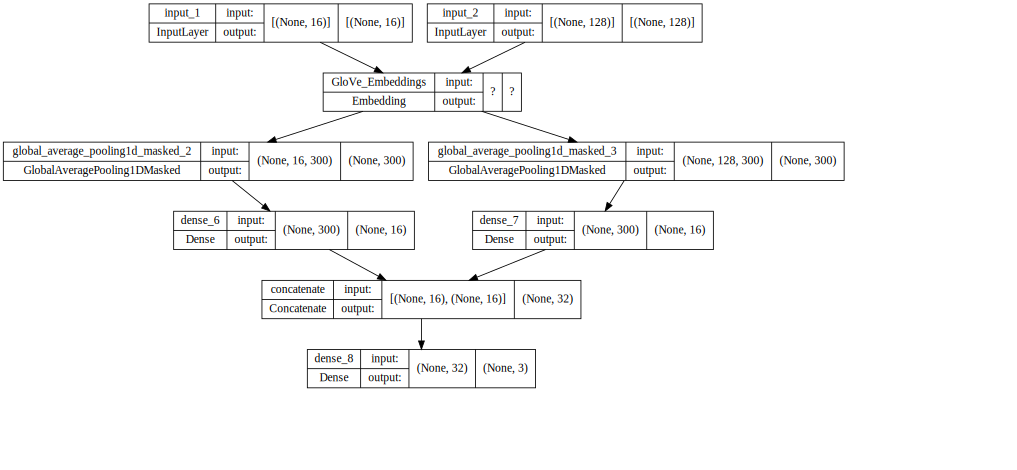

In [26]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model3_1, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate the model:

In [27]:
model3_1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_3_1 = model3_1.fit([x_train_aspect_pad_glove,
                           x_train_review_pad_glove],
                           y_train,
                           epochs=200,
                           batch_size=512,
                           validation_data=([x_dev_aspect_pad_glove, x_dev_review_pad_glove], y_dev),
                           verbose=1)



results_3_1 = model3_1.evaluate([x_test_aspect_pad_glove,
                                 x_test_review_pad_glove], y_test)
print('\n')
print('test_loss:', results_3_1[0], 'test_accuracy:', results_3_1[1])



Epoch 1/200
22/22 [==============================] - 1s 16ms/step - loss: 0.6591 - accuracy: 0.4461 - val_loss: 0.6275 - val_accuracy: 0.4535
Epoch 2/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6158 - accuracy: 0.4507 - val_loss: 0.6045 - val_accuracy: 0.4535
Epoch 3/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6017 - accuracy: 0.4507 - val_loss: 0.5941 - val_accuracy: 0.4542
Epoch 4/200
22/22 [==============================] - 0s 8ms/step - loss: 0.5918 - accuracy: 0.4560 - val_loss: 0.5839 - val_accuracy: 0.4775
Epoch 5/200
22/22 [==============================] - 0s 7ms/step - loss: 0.5820 - accuracy: 0.4969 - val_loss: 0.5739 - val_accuracy: 0.5233
Epoch 6/200
22/22 [==============================] - 0s 8ms/step - loss: 0.5722 - accuracy: 0.5367 - val_loss: 0.5640 - val_accuracy: 0.5495
Epoch 7/200
22/22 [==============================] - 0s 7ms/step - loss: 0.5628 - accuracy: 0.5639 - val_loss: 0.5546 - val_accuracy: 0.5691
Epoch 8/200


## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [28]:
# Try CNN or LSTM without pre-trained word embeddings in here:

input1 = Input(shape=(16, ))
input2 = Input(shape=(128,))
embed1 = embeddingLayer(input1)
embed2 = embeddingLayer(input2)
lstm_1 = LSTM(100, return_sequences = False)(embed1)
lstm_2 = LSTM(100, return_sequences = False)(embed2)

dense1 = Dense(16)(lstm_1)
dense2 = Dense(16)(lstm_2)
concatenate = keras.layers.Concatenate()([dense1, dense2])
output = Dense(3, activation = 'softmax')(concatenate)

model3_2 = keras.models.Model(inputs=[input1, input2], outputs = output)
model3_2.summary()

model3_2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_3_2 = model3_2.fit([x_train_aspect_pad_glove,
                           x_train_review_pad_glove],
                           y_train,
                           epochs=200,
                           batch_size=512,
                           validation_data=([x_dev_aspect_pad_glove, x_dev_review_pad_glove], y_dev),
                           verbose=1)



results_3_2 = model3_2.evaluate([x_test_aspect_pad_glove,
                                 x_test_review_pad_glove], y_test)
print('\n')
print('test_loss:', results_3_2[0], 'test_accuracy:', results_3_2[1])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 100)          160400      ['GloVe_Embeddings[4][0]'] 

#  Model 4: Another LSTM model

We can find that every aspect appears in the review sentence, which means we can extract the aspect information from the sentence. In most cases, the polarity of the aspect is determined by the content near it. Therefore, an LSTM can transfer the information of adjacent context to the aspect. We only need to extract the aspect vector to calculate its polarity, without analyzing the whole sentence.

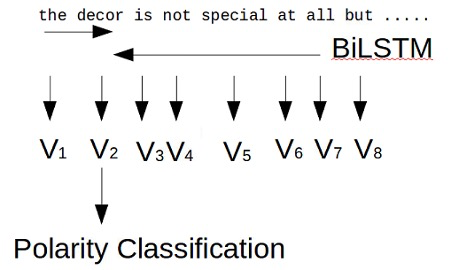

(This is a bit like a simplified version of the "unknown target" sequence tagging models discussed in lectures - but we're only trying to tag the one part of the sequence that we know corresponds to the aspect mention.)

In [29]:
def aspect_mask(reviews, aspects, dataset):
    mask = []
    for review,aspect,data in zip(reviews, aspects, dataset):
        find_aspect = False
        for j in range(5):
            aspect_num = len(aspect)
            aspect_str = " ".join(aspect)
            aspect_len = int(len(aspect_str) - 1) * (j+1)
            offset = 0
            for i,r in enumerate(review):
                if i + aspect_num <= len(review):
                    r_context = " ".join(review[i:i+aspect_num])
                    if r_context == aspect_str and offset + aspect_len >  int(data[3]) and offset + aspect_len <    int(data[4]):
                        find_aspect = True
                        sentence_mask = [0] * len(review)
                        sentence_mask[i:i+aspect_num] = [1] * aspect_num
                        mask.append(sentence_mask)
                        break
                    else:
                        offset += (len(r) + 1)
            if find_aspect:
                break

        if not find_aspect:
            for j in range(5):
                aspect_len = int(len(aspect_str) - 1) * (j+1)
                offset = 0
                for i,r in enumerate(review):
                    if i + aspect_num <= len(review):
                        r_context = " ".join(review[i:i+aspect_num])
                        if r_context.startswith(aspect_str) and offset + aspect_len >    int(data[3]) and offset + aspect_len <    int(data[4]):
                            find_aspect = True
                            sentence_mask = [0] * len(review)
                            sentence_mask[i:i+aspect_num] = [1] * aspect_num
                            mask.append(sentence_mask)
                            break
                        else:
                            offset += (len(r) + 1)
                if find_aspect:
                    break

        if not find_aspect:
            for j in range(5):
                aspect_len = int(len(aspect_str) - 1) * (j+1)
                offset = 0
                for i,r in enumerate(review):
                    if i + aspect_num <= len(review):
                        r_context = " ".join(review[i:i+aspect_num])
                        if r_context.endswith(aspect_str) and offset + aspect_len >    int(data[3]) and offset + aspect_len <    int(data[4]):
                            find_aspect = True
                            sentence_mask = [0] * len(review)
                            sentence_mask[i:i+aspect_num] = [1] * aspect_num
                            mask.append(sentence_mask)
                            break
                        else:
                            offset += (len(r) + 1)
                if find_aspect:
                    break

        if not find_aspect:
            print("annotation error:")
            print(data)
            sentence_mask = [0] * len(review)
            sentence_mask[16] = 1
            mask.append(sentence_mask)

        # if aspect_num > 1:
        #     print(mask[-1])

    return mask

x_train_aspect_mask = aspect_mask(x_train_review, x_train_aspect, train)
x_dev_aspect_mask = aspect_mask(x_dev_review, x_dev_aspect, val)
x_test_aspect_mask = aspect_mask(x_test_review, x_test_aspect, test)

print()
print()
print()
assert len(x_train_aspect_mask) == len(train)
assert len(x_test_aspect_mask) == len(x_test_aspect)

print(train[0])
print(x_train_aspect_mask[0])
print(train[1])
print(x_train_aspect_mask[1])
print(train[2])
print(x_train_aspect_mask[2])
print(train[3])
print(x_train_aspect_mask[3])
print(train[10319])
print(x_train_aspect_mask[10319])

annotation error:
['i love the food here, and although it is pricey, the entree comes with rice, naan, dal, and salad, which makes it worthwhile.', 'd al', 'neutral', '24', '28']



['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dinin

In [30]:
# although the name of function is review, it is not an error because of maxlen.

x_train_aspect_mask_pad = review_pad_glove(x_train_aspect_mask)
x_dev_aspect_mask_pad = review_pad_glove(x_dev_aspect_mask)
x_test_aspect_mask_pad = review_pad_glove(x_test_aspect_mask)
x_train_aspect_mask_pad[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [31]:
import tensorflow as tf

# Try CNN or LSTM without pre-trained word embeddings in here:

input1 = Input(shape=(128,))
embed = embeddingLayer(input1)
bi_lstm = Bidirectional(LSTM(100, return_sequences=True),
                        name = 'BiLSTM')(embed)
input2 = Input(shape=(128,))
dot = tf.keras.layers.Dot(axes=1)([bi_lstm, input2])
dense2 = Dense(16)(dot)
output = Dense(3, activation = 'softmax')(dense2)

model_4 = keras.models.Model(inputs = [input1, input2], 
                            outputs = output)
model_4.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_5[0][0]']                
                                                                                                  
 BiLSTM (Bidirectional)         (None, 128, 200)     320800      ['GloVe_Embeddings[6][0]']       
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

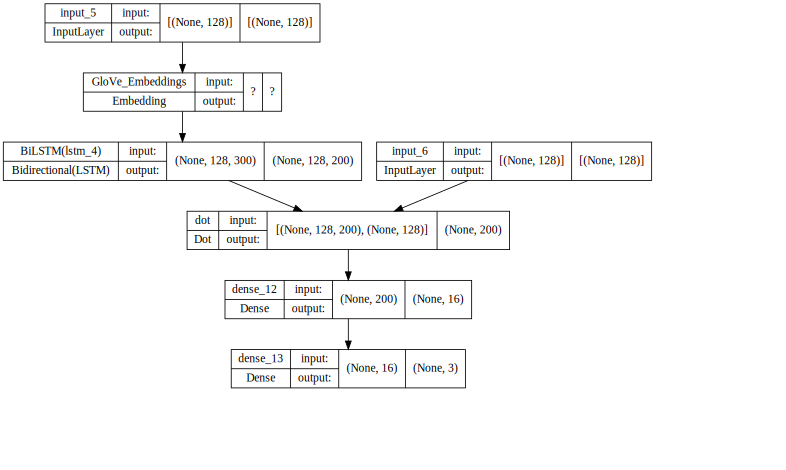

In [32]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_4, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [33]:
model_4.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history_4 = model_4.fit([x_train_review_pad_glove, 
                         x_train_aspect_mask_pad],
                       y_train,
                       epochs=16,
                       batch_size=512,
                       validation_data=([x_dev_review_pad_glove, 
                                         x_dev_aspect_mask_pad], 
                                        y_dev),
                       verbose=1)



results_4 = model_4.evaluate([x_test_review_pad_glove,
                              x_test_aspect_mask_pad], y_test)
print('\n')
print('test_loss:', results_4[0], 'test_accuracy:', results_4[1])

Epoch 1/16
22/22 [==============================] - 8s 200ms/step - loss: 0.5817 - accuracy: 0.5263 - val_loss: 0.5183 - val_accuracy: 0.6494
Epoch 2/16
22/22 [==============================] - 3s 157ms/step - loss: 0.4933 - accuracy: 0.6560 - val_loss: 0.4732 - val_accuracy: 0.6809
Epoch 3/16
22/22 [==============================] - 3s 157ms/step - loss: 0.4447 - accuracy: 0.6930 - val_loss: 0.4459 - val_accuracy: 0.7102
Epoch 4/16
22/22 [==============================] - 3s 156ms/step - loss: 0.4122 - accuracy: 0.7230 - val_loss: 0.4283 - val_accuracy: 0.7155
Epoch 5/16
22/22 [==============================] - 3s 155ms/step - loss: 0.3813 - accuracy: 0.7465 - val_loss: 0.4274 - val_accuracy: 0.7282
Epoch 6/16
22/22 [==============================] - 3s 155ms/step - loss: 0.3564 - accuracy: 0.7685 - val_loss: 0.4184 - val_accuracy: 0.7350
Epoch 7/16
22/22 [==============================] - 3s 155ms/step - loss: 0.3303 - accuracy: 0.7879 - val_loss: 0.4158 - val_accuracy: 0.7312
Epoch 